In [1]:
"""
Nice, you’ve now got a best model from Keras Tuner 🎯
From here there are **two big levers**:

1. **Make the model itself better** (architecture, regularization, hyperparams)
2. **Make the *data & training* setup better** (features, targets, training schedule)

I’ll give you concrete things you can do *right now* with code.

---

## 1. Fine-tune your current best model

You already have `best_model` and `best_hp`. Easiest improvement:
**keep training the same model with a smaller learning rate.**

```python
# Take the tuned model
best_model = tuner.hypermodel.build(best_hp)

# Optionally re-train from scratch with tuned hp
history = best_model.fit(
    X_train_normal,
    y_train,
    validation_data=(X_test_normal, y_test),
    epochs=100,
    callbacks=callbacks,
    verbose=0
)

# Now fine-tune with smaller lr
import keras

old_lr = best_hp.get("learning_rate")
fine_tune_lr = old_lr * 0.1

best_model.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
    metrics=["mae", "mse"]
)

history_ft = best_model.fit(
    X_train_normal,
    y_train,
    validation_data=(X_test_normal, y_test),
    epochs=50,
    callbacks=callbacks,
    verbose=0
)

best_model.evaluate(X_test_normal, y_test)
```

This alone can squeeze a bit more performance by “polishing” weights.

---

## 2. Add regularization (dropout / L2) and tune it

Right now your model is:

* Dense → Dense → Dense(1)

You can improve **generalization** by:

* Adding **L2 weight decay**
* Adding a **Dropout** layer

And tune their strength.

```python
import keras
import keras_tuner as kt

def build_model(hp: kt.HyperParameters):
    keras.utils.set_random_seed(42)

    units_1 = hp.Choice('units_1', [64, 100, 128])
    units_2 = hp.Choice('units_2', [64, 100, 128])
    lr      = hp.Choice('learning_rate', [0.001, 0.005, 0.01])

    # New: regularization hyperparams
    l2_factor = hp.Choice('l2_factor', [0.0, 1e-4, 1e-3])
    dropout_rate = hp.Choice('dropout_rate', [0.0, 0.1, 0.2])

    reg = keras.regularizers.l2(l2_factor) if l2_factor > 0 else None

    model = keras.Sequential(name="Model_A")
    model.add(keras.layers.Input(shape=(11,)))
    model.add(keras.layers.Dense(units_1, activation='relu',
                                 kernel_regularizer=reg))
    model.add(keras.layers.Dense(units_2, activation='relu',
                                 kernel_regularizer=reg))
    # Optional dropout layer
    if dropout_rate > 0:
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(1))

    model.compile(
        loss="mae",
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=["mae", "mse"]
    )
    return model
```

Then rerun your `GridSearch` (or better: switch to `RandomSearch` or `BayesianOptimization` so the search space can be larger):

```python
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=30,
    overwrite=True,
    directory="kt_dir",
    project_name="model_a_reg"
)

tuner.search(
    X_train_normal, y_train,
    validation_data=(X_test_normal, y_test),
    epochs=150,
    callbacks=callbacks,
    verbose=1
)
```

---

## 3. Tune batch size & number of layers

Two more impactful knobs:

* **batch_size** (small batches can help generalization sometimes)
* **depth** (1, 2, or 3 hidden layers)

### Example: tuning batch size

```python
batch_size = hp.Choice("batch_size", [16, 32, 64, 128])
...
# in tuner.search:
tuner.search(
    X_train_normal,
    y_train,
    validation_data=(X_test_normal, y_test),
    epochs=150,
    batch_size=best_hp.get("batch_size"),   # if you add it
    callbacks=callbacks,
    verbose=1
)
```

Better pattern: put `batch_size` also in `search` as:

```python
tuner.search(
    X_train_normal,
    y_train,
    validation_data=(X_test_normal, y_test),
    epochs=150,
    callbacks=callbacks,
    verbose=1,
    batch_size=hp.Choice("batch_size", [32, 64, 128])  # in a custom run_trial
)
```

But the simple way is: try a few batch sizes manually once you have a good model.

### Example: tuning number of hidden layers

You can optionally add a 3rd dense layer only in some trials:

```python
def build_model(hp):
    keras.utils.set_random_seed(42)

    lr = hp.Choice("learning_rate", [0.001, 0.005, 0.01])
    num_hidden = hp.Choice("num_hidden", [1, 2, 3])

    model = keras.Sequential(name="Model_A")
    model.add(keras.layers.Input(shape=(11,)))

    units = hp.Choice("units", [64, 100, 128])

    for i in range(num_hidden):
        model.add(keras.layers.Dense(units, activation="relu"))

    model.add(keras.layers.Dense(1))

    model.compile(
        loss="mae",
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=["mae", "mse"],
    )
    return model
```

---

## 4. Improve input / target side (often bigger gains)

Sometimes the **biggest MAE improvement** comes from data, not layers:

1. **Check scaling of targets (`y`)**

   * If `y` has a long tail, try a **log transform**: `y_log = np.log1p(y)`
   * Train the model on `y_log`, and when predicting, invert with `np.expm1(pred)`.

2. **Handle outliers**

   * Clip extreme values of target or features.
   * Or train with a robust loss (e.g., Huber, which you already played with).

3. **Feature engineering**

   * Add interactions: `x1 * x2`, ratios, or bucketed versions of continuous features.
   * If there are categorical variables, use proper one-hot or embeddings instead of arbitrary numeric codes.

4. **Cross-validation**

   * Instead of a single train/val split, use **KFold** and average MAE.
   * This gives more stable hyperparameter selection and can reveal overfitting to a specific split.

---

## 5. Quick checklist – what I’d do in your notebook

If you want a practical order:

1. ✅ **Restart kernel** and use only `keras` + `keras_tuner` (no `tf.keras` models/callbacks).
2. ✅ Keep your current best hyperparams and:

   * Recompile with `lr * 0.1`
   * Fine-tune 30–50 more epochs with callbacks.
3. ✅ Extend tuner search:

   * Add **L2 + Dropout** hyperparams.
   * Maybe allow `num_hidden` ∈ {1, 2, 3}.
   * Switch to `RandomSearch` with ~30 trials.
4. ✅ Examine distribution of `y_train`:

   * If skewed → try `log1p` target.
5. ✅ If MAE still doesn’t move much, we’re probably close to the **information limit of your data** (noise level, missing features, etc.).

If you paste your **best_model.evaluate output** and a short description of what the target is (range, approx noise), I can suggest very specific next tweaks.

"""

'\nNice, you’ve now got a best model from Keras Tuner 🎯\nFrom here there are **two big levers**:\n\n1. **Make the model itself better** (architecture, regularization, hyperparams)\n2. **Make the *data & training* setup better** (features, targets, training schedule)\n\nI’ll give you concrete things you can do *right now* with code.\n\n---\n\n## 1. Fine-tune your current best model\n\nYou already have `best_model` and `best_hp`. Easiest improvement:\n**keep training the same model with a smaller learning rate.**\n\n```python\n# Take the tuned model\nbest_model = tuner.hypermodel.build(best_hp)\n\n# Optionally re-train from scratch with tuned hp\nhistory = best_model.fit(\n    X_train_normal,\n    y_train,\n    validation_data=(X_test_normal, y_test),\n    epochs=100,\n    callbacks=callbacks,\n    verbose=0\n)\n\n# Now fine-tune with smaller lr\nimport keras\n\nold_lr = best_hp.get("learning_rate")\nfine_tune_lr = old_lr * 0.1\n\nbest_model.compile(\n    loss="mae",\n    optimizer=keras

In [2]:
"""
2. Use a smarter tuner than GridSearch

GridSearch explodes combinatorially and often wastes trials. For neural nets, RandomSearch or BayesianOptimization usually find better configs faster.
"""

'\n2. Use a smarter tuner than GridSearch\n\nGridSearch explodes combinatorially and often wastes trials. For neural nets, RandomSearch or BayesianOptimization usually find better configs faster.\n'

In [3]:
!pip install keras-tuner

In [12]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
import keras_tuner as kt 
from sklearn.model_selection import train_test_split 
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.utils import plot_model

In [5]:
# Import data 
insurance = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/refs/heads/master/insurance.csv')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
# Create X & y and train test splits 

X = insurance.drop('charges', axis=1)
y = insurance.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Preprocess Data

# 1. Create transformerabs

col_transformer = make_column_transformer(
    (MinMaxScaler(), ['age', 'bmi', 'children']),
    (OneHotEncoder(handle_unknown='ignore'), ['sex', 'smoker', 'region'])
)

# 2. Fit training data 
col_transformer.fit(X_train) 

# 3. Transform train and test data 
X_train_normal = col_transformer.transform(X_train)
X_test_normal = col_transformer.transform(X_test) 

X_train_normal[:2], X_test_normal[:2]

(array([[0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        ],
        [0.63043478, 0.22491256, 0.        , 1.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 0.        ,
         0.        ]]),
 array([[0.58695652, 0.24791499, 0.4       , 1.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 0.        ,
         0.        ],
        [0.39130435, 0.37826204, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        ]]))

In [26]:
# Create build_model function

def build_model(hp: kt.HyperParameters):

    # 1. Set keras seed
    keras.utils.set_random_seed(42)

    # 2. Create options 
    units = hp.Choice('units_1', [100, 128, 256])
    lr = hp.Choice('learning_rate', [0.05, 0.01])
    num_hidden = hp.Choice('num_hidden', [2, 3])

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(11,)))

    for unit in range(num_hidden):
        model.add(keras.layers.Dense(units, activation='relu'))

    model.compile(
        loss='mae',
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        metrics=['mae', 'mse']
    )

    return model

In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0,
        min_lr=1e-5
    )
]

In [28]:
tuner = kt.GridSearch(
    hypermodel=build_model, 
    objective='val_mae', 
    overwrite=True, 
    seed=42, 
    directory='kt_dir', 
    project_name='model_a_grid_2'
)

In [29]:
tuner.search(
    X_train_normal, 
    y_train, 
    validation_data=(X_test_normal, y_test),
    epochs=150, 
    callbacks=callbacks, 
    verbose=1
)

Trial 12 Complete [00h 00m 07s]
val_mae: 2674.27294921875

Best val_mae So Far: 2619.53466796875
Total elapsed time: 00h 01m 41s


In [36]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Units : ", best_hp.get('num_hidden'))
print('Best LR : ', best_hp.get('learning_rate'))

best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

history = best_model.fit(
    X_train_normal,
    y_train,
    validation_data=(X_test_normal, y_test), 
    epochs=150, 
    callbacks=callbacks, 
    verbose=1
)

Best Units :  3
Best LR :  0.05


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,560 (135.00 KB)

 Trainable params: 34,560 (135.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 11301.3984 - mae: 11301.3984 - mse: 256620784.0000 - val_loss: 7112.2612 - val_mae: 7112.2612 - val_mse: 114595872.0000 - learning_rate: 0.0500
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5722.5522 - mae: 5722.5522 - mse: 86189256.0000 - val_loss: 3719.9709 - val_mae: 3719.9709 - val_mse: 59662488.0000 - learning_rate: 0.0500
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4132.0952 - mae: 4132.0952 - mse: 66720124.0000 - val_loss: 3594.5996 - val_mae: 3594.5996 - val_mse: 60745032.0000 - learning_rate: 0.0500
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4039.5518 - mae: 4039.5518 - mse: 66747432.0000 - val_loss: 3634.3088 - val_mae: 3634.3088 - val_mse: 56530316.0000 - learning_rate: 0.0500
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4001.4922 - mae: 4001.4922 - mse: 63362716.0000 - val_loss: 3598.3828 - val_mae: 3598.3828 - val_mse: 57785464.0000 - learning_rate: 0.0500


<Axes: >

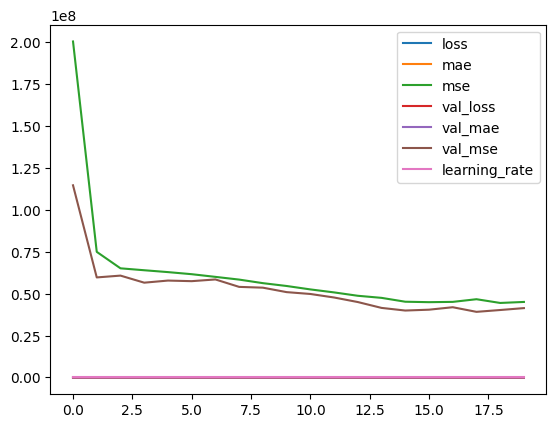

In [37]:
pd.DataFrame(history.history).plot()